## Énoncé
L’entreprise "Place de marché” est une plateforme en ligne où des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. 
Dans l'optique d'un passage à l'échelle et rendre l’expérience utilisateur des vendeurs et des acheteurs la plus fluide possible, il devient nécessaire d'automatiser cette tâche.
## Mission
Consultant au sein de cette entreprise, notre mission est de réaliser une première étude de faisabilité d'un moteur de classification automatisation des articles, basé sur les images et leurs descriptions.

In [16]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from sklearn.decomposition import LatentDirichletAllocation
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
import os
from os import listdir
import transformers
from transformers import *
import tensorflow_hub as hub
import tensorflow_text 
os.environ["TF_KERAS"]='1'
import logging
from matplotlib.image import imread
from PIL import Image
import random
import cv2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump
from scipy.ndimage import gaussian_filter,median_filter
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

## Prétraitements des données textuelles

Lecture du jeu de données:

In [17]:
path = 'C:/Users/33624/Documents/Data scientist/projet 6/Flipkart/'
df_articles = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
df_articles.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

### Traitement des catégories

Un aperçu de la variable des catégories de produits:

In [18]:
df_articles['product_category_tree'].head()

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

Définissons une fonction pour séparer les différents niveaux des catégories de produits:

In [19]:
def split_categories(category, level):
    '''Function that removes special characters, '["','"]',' >> ' 
    in order to separate the categories into three subclasses.
    ----------
     Parameters:
               category: (string), the different product categories
               level: (integer), the level of categories
     Returns:
            cat[level]: (string), string of the level categories
     '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    '''Function that returns the first categories of product.
    ----------
     Parameters:
               category: (string), the different product categories
     Returns:
            split_categories(category,0): (string), the first categories of product  
     '''
    return split_categories(category,0)

def split_categories_2(category):
    '''Function that returns the second categories of product.
    ----------
     Parameters:
               category: (string), the different product categories
     Returns:
            split_categories(category,0): (string), the second categories of product    
     '''
    return split_categories(category,1)

def split_categories_3(category):
    '''Function that returns the third categories of product.
    ----------
     Parameters:
               category:  (string ) the different product categories                     
     Returns:
            split_categories(category,0): (string), the third categories of product   
     '''
    return split_categories(category,2)

def detail_categories(df, feature):
    '''Function that creates the features containing the three subclasses of product categories.
    ----------
     Parameters:
               dataframe:  (dataframe ) the dataframe of product                    
     Returns:
            dataframe:  (dataframe ) the dataframe of product   
     '''
    df['cat_level_1'] = df[feature].apply(split_categories_1)
    df['cat_level_2'] = df[feature].apply(split_categories_2)
    df['cat_level_3'] = df[feature].apply(split_categories_3)
    return df

Séparons les différents niveaux catégories des produits en trois sous classes:

In [20]:
df_detail = detail_categories(df_articles, 'product_category_tree')

Un aperçu des trois niveaus de catégories crées:

In [21]:
df_detail[['cat_level_1', 'cat_level_2', 'cat_level_3']].head()

cat_level_1             cat_level_2       cat_level_3
0  Home Furnishing  Curtains & Accessories          Curtains
1        Baby Care        Baby Bath & Skin  Baby Bath Towels
2        Baby Care        Baby Bath & Skin  Baby Bath Towels
3  Home Furnishing               Bed Linen         Bedsheets
4  Home Furnishing               Bed Linen         Bedsheets

Affichons le premier niveau des catégories de produits:

In [22]:
df_detail['cat_level_1'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Leur nombre:

In [23]:
df_detail['cat_level_1'].nunique()

7

Le nombre de produits par catégories du premier niveau:

In [24]:
df_detail.groupby('cat_level_1')['uniq_id'].count()

cat_level_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

Définissons le dataframe utile à notre problematique:

In [25]:
df_product = df_detail[['product_name', 'description','cat_level_1' ]]
df_product = df_product.rename(columns={'cat_level_1': 'category'})
df_product['category'] = df_product['category'].replace({'Home Furnishing': 'Furnishing',
                                         'Baby Care': 'Baby', 
                                         'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})
le = preprocessing.LabelEncoder()
df_product["label"] = le.fit_transform(df_product["category"])
df_product.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description    category  label  
0  Key Features of Elegance Polyester Multicolor ...  Furnishing      4  
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby      0  
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby      0  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Furnishing      4  
4  Key Features of Jaipur Print Cotton Floral Kin...  Furnishing      4

Sa taille:

In [26]:
print ("Le jeu de données compte {} lignes et {} variables".format(df_product.shape[0], df_product.shape[1]))

Le jeu de données compte 1050 lignes et 4 variables


Analysons les valeurs manquantes:

In [27]:
df_product.isna().sum()

product_name    0
description     0
category        0
label           0
dtype: int64

### Nettoyage du texte

Définissons des fonctions utiles au nettoyage du texte:

In [28]:
def tokenizer_fct(sentence) :
    """ Function that make a tokenization of sentences.
    ----------
    Parameters:
               sentence:(string), a sentence
    Returns:
            word_tokens:(string), words tokens
    """     
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def pos_tag(word_tokens):
    """ Function that removes adjectives and adverbs from the list of words.
    ----------
    Parameters:
               word_tokens:(string), the list of words
    Returns:
            word_tokens:(string), the list of words cleaned
    """ 
    a=nltk.pos_tag(word_tokens)
    word_tokens = [a[i][0] for i in range(len(a)) if (a[i][1] != 'JJ') and (a[i][1] != 'RB')]
    return word_tokens  

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    """  Function that removes the stopwords.
    ----------
    Parameters:
               list_words : (string), a list of words
    Returns:
              filtered_w2:(string), a list of words cleaned
    """  
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

def lower_start_fct(list_words) :
    """ Function that lowercase the words.
    ----------
    Parameters:
               list_words : (string), a list of words
    Returns:
             lw:(string), lowercase words
    """  
    lw = [w.lower() for w in list_words ]
    return lw

def lemma_fct(list_words) :
    """ Function that make the lemmatization of words.
    ----------
    Parameters:
               list_words : list_words : (string), a list of words
    Returns:
              lem_w:(string), a list of words lemmatizated
    """  
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def transform_bow_lem_fct(desc_text) :
    """ Text preparation function for bag of words with lemmatization
         (Countvectorizer and Tf_idf).
    ----------
    Parameters:
                desc_text : (string),a text
    Returns:
               transf_desc_text:(string), text ready for bag of words 
    """  
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = pos_tag(word_tokens)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

def transform_bow_fct(desc_text) :
    """ Text preparation function for bag of words without lemmatization ( Word2Vec).
    ----------
    Parameters:
                desc_text : (string),a text
    Returns:
               transf_desc_text:(string), text ready for bag of words 
    """ 
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = pos_tag(word_tokens)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)  
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

def transform_dl_fct(desc_text) :
    """ Text preparation function for Deep learning (USE et BERT)
    Parameters:
                desc_text : (string),a text
    Returns:
               transf_desc_text:(string), text ready for bag of words 
    """ 
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens) 
    transf_desc_text = ' '.join(lw)
    return transf_desc_text



Néttoyons nos features textuelles:

In [29]:
df_product['product_name_bow_lem'] = df_product['product_name'].apply(lambda x : transform_bow_lem_fct(x))
df_product['description_bow_lem'] = df_product['description'].apply(lambda x : transform_bow_lem_fct(x))
df_product['product_name_bow'] = df_product['product_name'].apply(lambda x : transform_bow_fct(x))
df_product['description_bow'] = df_product['description'].apply(lambda x : transform_bow_fct(x))
df_product['product_name_dl'] = df_product['product_name'].apply(lambda x : transform_dl_fct(x))
df_product['description_dl'] = df_product['description'].apply(lambda x : transform_dl_fct(x))

Affichons un exemple de phrase nettoyée:

In [30]:
df_product.loc[df_product['description'].index==3,'description'][3]

'Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet (1 Bedsheet,2 Pillow Cover, Multicolor) General Brand SANTOSH ROYAL FASHION Machine Washable Yes Type Flat Material Cotton Model Name Gold Design Royal Cotton Printed Wedding & Gifted Double Bedsheet With 2 Pillow cover Model ID goldbedi-38 Color Multicolor Size King Fabric Care Machine Wash, Do Not Bleach Dimensions Flat Sheet Width 90 inch / 230 cm Fitted Sheet Width 228 cm Pillow Cover Width 16 inch / 43 cm Pillow Cover Length 28 inch / 72 cm Fitted Sheet Depth 280 cm Fitted Sheet Length 278 cm Flat Sheet Depth 282 cm Flat Sheet Length 110 inch / 280 cm In the Box Number of Contents in Sales Package 1 Sales Package 1 Bedsheet,2 Pillow Cover'

In [31]:
df_product.loc[df_product['description_bow_lem'].index==3,'description_bow_lem'][3]

'key feature santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfact wedding gifting specification santosh royal fashion cotton printed king sized double bedsheet bedsheet,2 pillow cover multicolor general brand santosh royal fashion machine washable yes type flat material cotton model name gold design royal cotton printed wedding gifted double bedsheet with pillow cover model goldbedi color multicolor size king fabric care machine wash bleach dimension flat sheet width inch 230 fitted sheet width 228 pillow cover width inch pillow cover length inch fitted sheet depth 280 fitted sheet length 278 flat sheet depth 282 flat sheet length 110 inch 280 box number content sale package sale package bedsheet,2 pillow cover'

Créons des features relatives aux noms des produits et leurs descriptions:

In [32]:
df_product['product_name & description_bow_lem'] = df_product['product_name_bow_lem'] + " " + df_product['description_bow_lem']
df_product['product_name & description_bow'] = df_product['product_name_bow'] + " " + df_product['description_bow']
df_product['product_name & description_dl'] = df_product['product_name_dl'] + " " + df_product['description_dl']

## Bag of word - Tf-idf

Définissons les models CountVectorizer et Tf-idf:

In [33]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

#### Première de l'approche
Nous decidons dans cette approche de faire le fit et transform de nos models sur la feature « product_name » + « description » :

In [34]:
cv_fit_1 = cvect.fit(df_product['product_name & description_bow_lem'])
ctf_fit_1 = ctf.fit(df_product['product_name & description_bow_lem'])

cv_transform_1 = cvect.transform(df_product['product_name & description_bow_lem'])  
ctf_transform_1 = ctf.transform(df_product['product_name & description_bow_lem']) 

#### Deuxième approche
Nous decidons dans cette approche de faire le  fit sur « product_name » et transform sur « product_name » + « description » 

In [35]:
cv_fit_2 = cvect.fit(df_product['product_name_bow_lem'])
ctf_fit_2 = ctf.fit(df_product['product_name_bow_lem'])

cv_transform_2 = cvect.transform(df_product['product_name & description_bow_lem'])  
ctf_transform_2 = ctf.transform(df_product['product_name & description_bow_lem']) 

### Réduction de dimension PCA
Nous utliserons la réduction PCA afin de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)

In [19]:
print("-----------------")
print("Première approche")
print("-----------------")
print("Dimensions dataset CountVectorizer avant réduction PCA : ", cv_transform_1.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_cv_1= pca.fit_transform(cv_transform_1.toarray())
print("Dimensions dataset CountVectorizer après réduction PCA : ", feat_pca_cv_1.shape)
print("Dimensions dataset Tf-idf avant réduction PCA : ", ctf_transform_1.shape)
feat_pca_ctf_1= pca.fit_transform(ctf_transform_1.toarray())
print("Dimensions dataset Tf-idf après réduction PCA : ", feat_pca_ctf_1.shape)
print("-----------------")
print("Deuxième approche")
print("-----------------")
print("Dimensions dataset CountVectorizer avant réduction PCA : ", cv_transform_2.shape)
feat_pca_cv_2= pca.fit_transform(cv_transform_2.toarray())
print("Dimensions dataset CountVectorizer après réduction PCA : ", feat_pca_cv_2.shape)
print("Dimensions dataset Tf-idf avant réduction PCA : ", ctf_transform_2.shape)
feat_pca_ctf_2= pca.fit_transform(ctf_transform_2.toarray())
print("Dimensions dataset Tf-idf après réduction PCA : ", feat_pca_ctf_2.shape)

-----------------
Première approche
-----------------
Dimensions dataset CountVectorizer avant réduction PCA :  (1050, 5015)
Dimensions dataset CountVectorizer après réduction PCA :  (1050, 764)
Dimensions dataset Tf-idf avant réduction PCA :  (1050, 5015)
Dimensions dataset Tf-idf après réduction PCA :  (1050, 903)
-----------------
Deuxième approche
-----------------
Dimensions dataset CountVectorizer avant réduction PCA :  (1050, 2114)
Dimensions dataset CountVectorizer après réduction PCA :  (1050, 753)
Dimensions dataset Tf-idf avant réduction PCA :  (1050, 2114)
Dimensions dataset Tf-idf après réduction PCA :  (1050, 868)


### Réduction de dimension T-SNE
Faisons une réduction de dimension en 2 composantes T-SNE pour affichage en 2D des catégories de produits:

Définissons deux fonctions, une pour calculer le Tsne, déterminer des clusters et calculer ARI entre vrais catégorie et n° de clusters et une autre pour visualiser les résultats du Tsne selon les vraies catégories et selon les clusters:

In [36]:
cat_num = [df_product['label'][i] for i in range(len(df_product))]   # list of labels
cat_list = list(set(df_product['category']))       # list of categories

def ARI_fct(features,df_cat) :
    """Function to calculate Tsne, determine clusters and calculate ARI between 
    true category and number of clusters.
    ----------
    Parameters:
               features : (sparse matrix of type '<class 'numpy.int64'>), 
                           CountVectorizer,Tf-idf,... matrix
                df_cat: categories of product        
    Returns:
              ARI: adjusted_rand_scored
              df_tsne: dafaframe of Tsne values
              cls.labels_: clusters labels
    """
    time1 = time.time()
    num_labels=len(cat_list)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df_cat

    
    # Determination of clusters from data after Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    df_tsne["cluster"] = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, df_tsne, cls.labels_

def TSNE_visu_fct(df_tsne, cat_num, labels, ARI) :
    """Function to visualize Tsne according to true categories and clusters 
    and print ARI.
    ----------
    Parameters:
               df_tsne: dafaframe of Tsne values
               cat_num: true categories labels
               labels: clusters labels
               ARI: adjusted_rand_scored
    Returns:
             display graphics and print ARI
    """
    fig = plt.figure(figsize=(20,11))
    
    ax = fig.add_subplot(121)
    sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
    plt.title('TSNE selon les vraies classes', fontsize = 25, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
    plt.legend(prop={'size': 10},title="Categories") 
    
    ax = fig.add_subplot(122)
    sns.scatterplot(
    x="tsne1", y="tsne2",hue="cluster",palette=sns.color_palette('tab10', n_colors=7), 
    s=50, alpha=0.6,data=df_tsne,legend="brief")
    plt.title('TSNE selon les clusters', fontsize = 25, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
    plt.legend(prop={'size': 11}, title="Clusters") 
    
    plt.show()
    print("ARI : ", ARI)

Appliquons cette fonction à nos données:

In [21]:
print("-----------------")
print("Deuxième approche")
print("-----------------")
print("CountVectorizer : ")
ARI, df_tsne, labels = ARI_fct(feat_pca_cv_2, df_product["category"])
print()
print("Tf-idf : ")
ARI, df_tsne, labels = ARI_fct(feat_pca_ctf_2, df_product["category"])
print("-----------------")
print("Première approche")
print("-----------------")
print("CountVectorizer : ")
ARI, df_tsne, labels = ARI_fct(feat_pca_cv_1, df_product["category"])
print()
print("Tf-idf : ")
ARI, df_tsne, labels = ARI_fct(feat_pca_ctf_1, df_product["category"])

-----------------
Deuxième approche
-----------------
CountVectorizer : 
ARI :  0.4092 time :  10.0

Tf-idf : 
ARI :  0.4839 time :  8.0
-----------------
Première approche
-----------------
CountVectorizer : 
ARI :  0.4567 time :  10.0

Tf-idf : 
ARI :  0.5344 time :  8.0


La premiére approche avec le model Tf-idf est celle offrant des meilleurs resultats:

Visualissons les résultats:

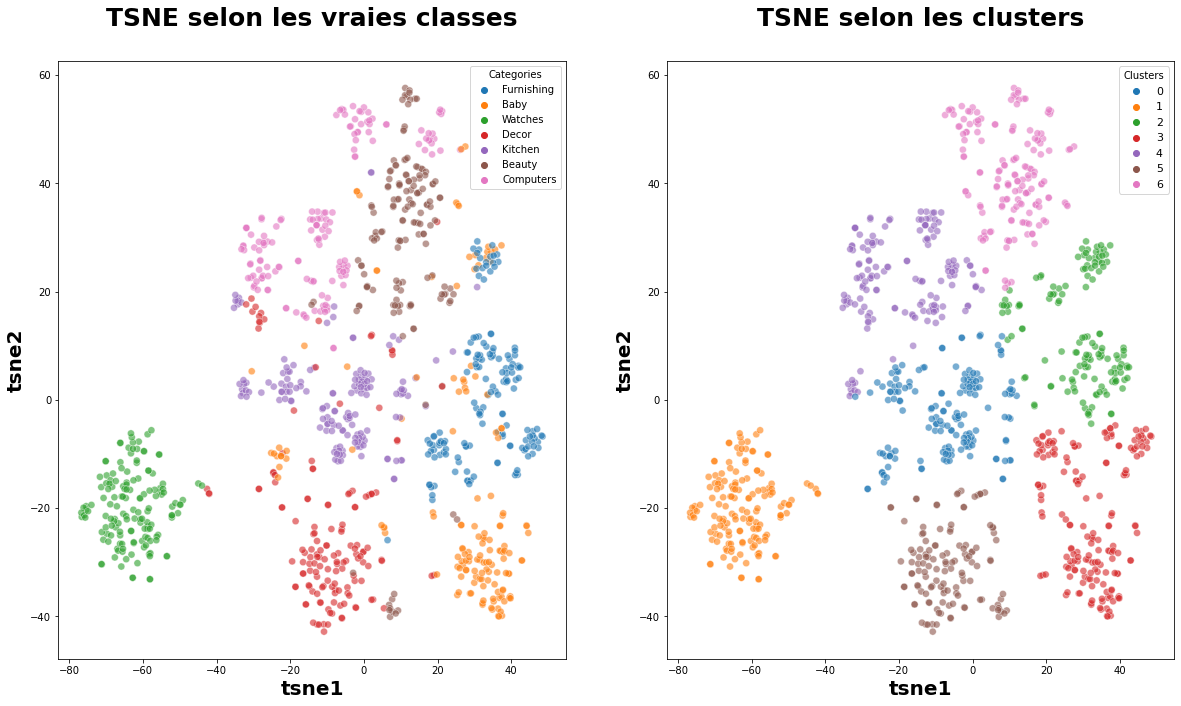

ARI :  0.5344


In [22]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Le graphique des catégorie réelles montre assez clairement que les produits sont relativement bien séparés selon les catégories réelles, la comparaison de la similarité de la catégorisation (catégorie réelle / cluster k-means) via l’adjusted Rand Score (ARI) donne une valeur 0.5, confirmant ainsi le visuel et donc la faisabilité de classer automatiquement les produits. 

#### Matrice de confusion

Définissons une fonction pour reordonner la matrice de confusion et affichons différents resultats de la classification:

In [23]:
def conf_mat_transform(y_true,y_pred) :
    """Function that reorder the confusion matrix.
    ----------
    Parameters:
               y_true: the true clusters
               y_pred: the predicted clusters
    Returns:
               labels['y_pred_transform'] : Matches of predicted clusters
               print the cluster matching
    """
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(cat_num, labels)
conf_mat = metrics.confusion_matrix(cat_num, cls_labels_transform)
print("---------------------")
print("Classification Report:")
print("---------------------")
print(metrics.classification_report(cat_num, cls_labels_transform))

---------------------
Classification Report:
---------------------
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       150
           1       0.62      0.65      0.64       150
           2       0.69      0.68      0.68       150
           3       0.88      0.74      0.80       150
           4       0.58      0.53      0.56       150
           5       0.77      0.81      0.79       150
           6       0.98      1.00      0.99       150

    accuracy                           0.72      1050
   macro avg       0.73      0.72      0.73      1050
weighted avg       0.73      0.72      0.73      1050



Affichons la heatmap de la matrice de confusion:

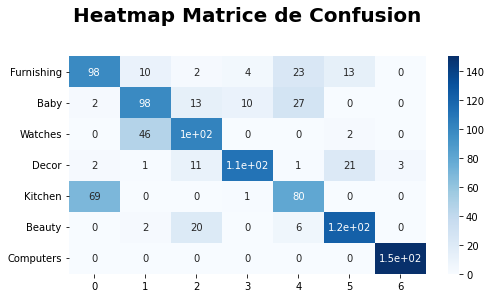

In [24]:
list_labels = ['Furnishing', 'Baby', 'Watches','Decor', 'Kitchen',
               'Beauty', 'Computers']
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,4))
fig=sns.heatmap(df_cm, annot=True, cmap="Blues")
title=plt.title('Heatmap Matrice de Confusion', fontsize = 20, pad = 35, fontweight = 'bold')

Nous obtenons des resultats assez satisfaisant avec une accuracy de 72%, confortant l'idée de la faisabilité de classer automatiquement les produits. 

## Word2Vec

Utlisons l'approche de type word/sentence embedding classique avec Word2Vec:

Affichons la taille maximale des tokens crées:

In [27]:
df_product['length_bow'] = df_product['product_name & description_bow'].apply(lambda x : len(word_tokenize(x)))
df_product['length_dl'] = df_product['product_name & description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length product_name & description bow : ", df_product['length_bow'].max())
print("max length product_name & description dl : ", df_product['length_dl'].max())

max length product_name & description bow :  352
max length product_name & description dl :  637


#### Création du modèle Word2Vec

In [28]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 355 
sentences = df_product['product_name & description_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [29]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=0)
#                                                
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4765
Word2Vec trained


In [30]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4766


#### Création de la matrice d'embedding

In [31]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4766, 300)


#### Création du modèle d'embedding

In [32]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 355)]             0         
                                                                 
 embedding (Embedding)       (None, 355, 300)          1429800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,429,800
Trainable params: 1,429,800
Non-trainable params: 0
_________________________________________________________________


#### Exécution du modèle

In [33]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 4ms/step


(1050, 300)

#### Affichage des résultats

In [34]:
ARI, df_tsne, labels = ARI_fct(embeddings, df_product["category"])

ARI :  0.4004 time :  8.0


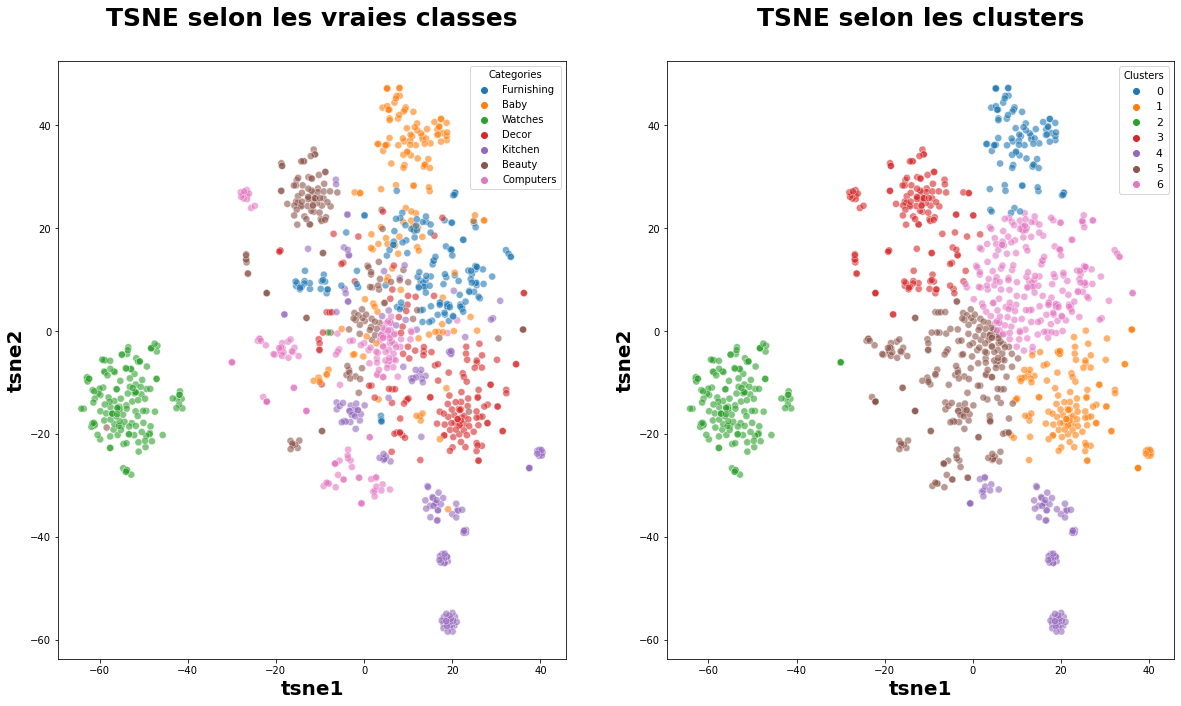

ARI :  0.4004


In [37]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Nous obtenons un ARI de 0.4 dans l'ordre de grandeur des résultats obtenus avec les techniques plus simple bag of words

## BERT 
Utilisons une approche de type word/sentence embedding avec BERT

#### Fonctions communes

In [38]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Sentence preparation function.
    ----------
    Parameters:
               sentences: the sentences
               bert_tokenizer: Bert tokenizer
               max_length: the maximum length (in number of tokens) 
                           for the inputs to the transformer model
               
    Returns:
               input_ids : imputs of model
               token_type_ids: token types
               attention_mask: attention mask
               bert_inp_tot: total bert imputs       
    """
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    """Features creation function.
    ----------
    Parameters:
               model: the model
               model_type: the type of model
               sentences: the sentences
               max_length: the maximum length (in number of tokens) 
                           for the inputs to the transformer model
            
               b_size: batch size
               mode: the mode, HuggingFace or hub Tensorflow
               
    Returns:
               features_bert : the bert sentences
               last_hidden_states_tot: the hidden total states       
    """
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT HuggingFace

#### 'bert-base-uncased'

In [39]:
max_length = 500
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_product['product_name & description_dl'].to_list()

In [40]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 7s 7s/step
temps traitement :  801.0


In [41]:
ARI, df_tsne, labels = ARI_fct(features_bert,  df_product["category"])

ARI :  0.3109 time :  6.0


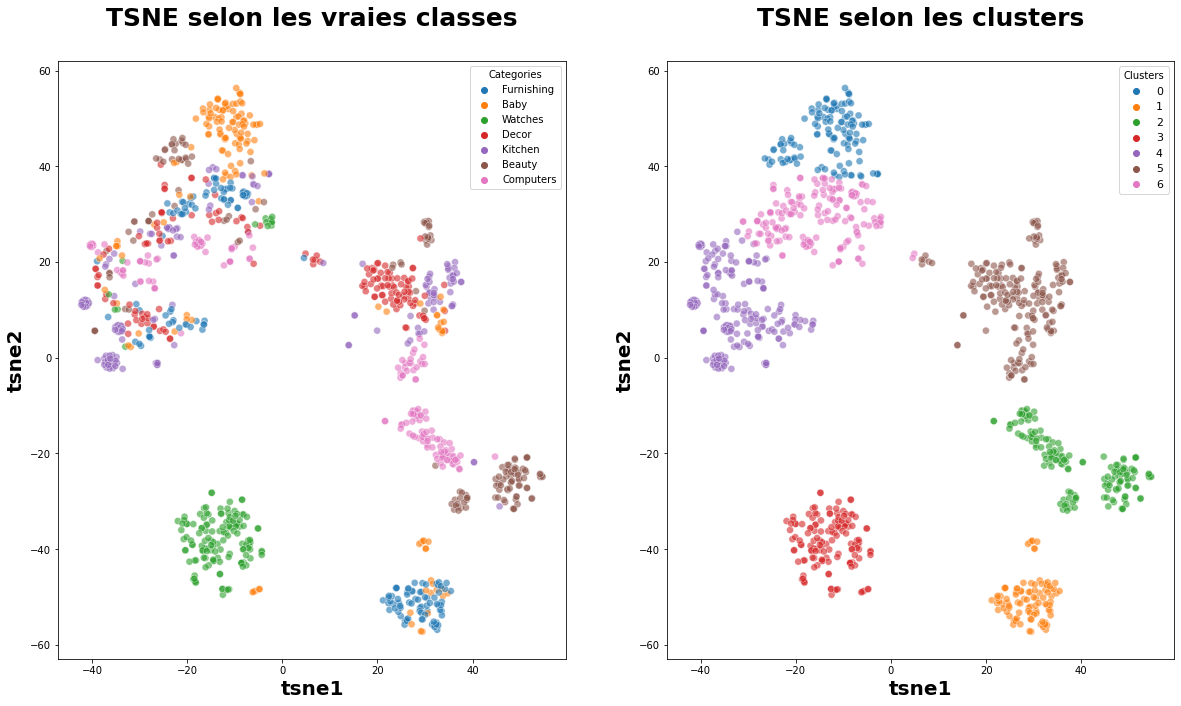

ARI :  0.3109


In [42]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

### BERT hub Tensorflow

In [43]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [44]:
sentences = df_product['product_name & description_dl'].to_list()

In [45]:
max_length = 500
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  940.0


In [46]:
ARI, df_tsne, labels = ARI_fct(features_bert,  df_product["category"])

ARI :  0.3095 time :  6.0


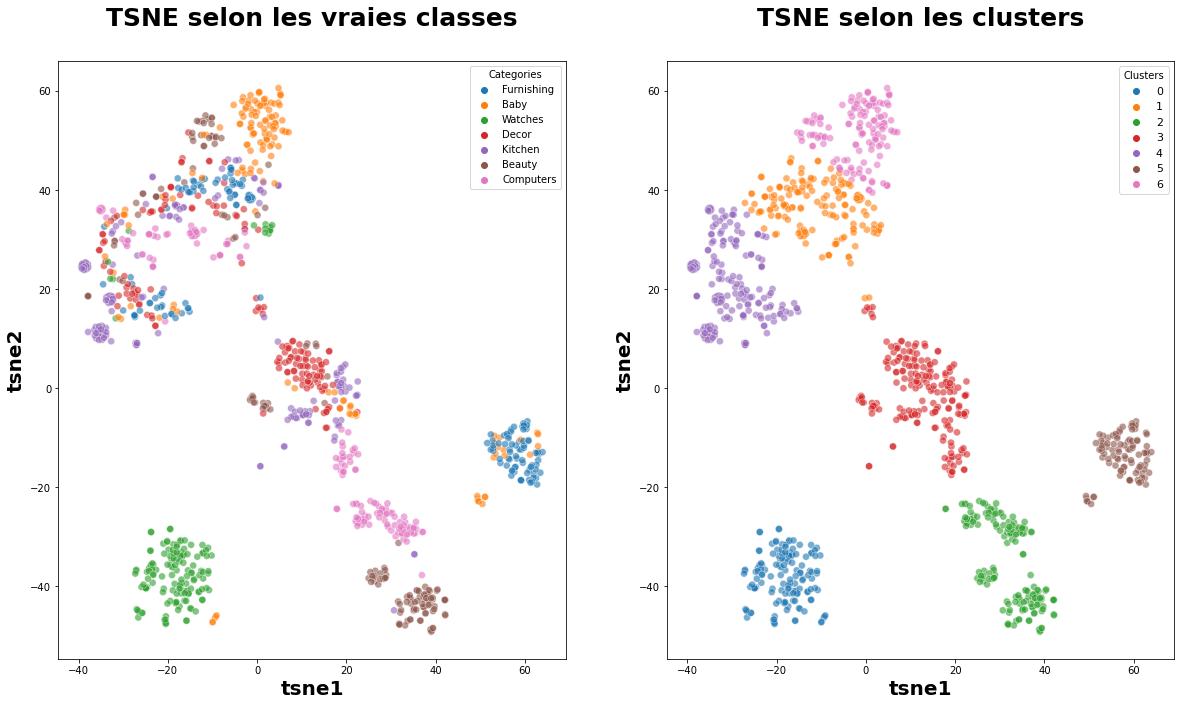

ARI :  0.3095


In [47]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Nous obtenons en utlisant les models Bert un ARI de 0.3 un peu inferieur aux résultats obtenus via les techniques plus simple de  bag of words Tf-idf.

### USE - Universal Sentence Encoder

Utilisons l'approche universal sentence encoder pour la classification de nos données textuelles:

In [48]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Définissons la fonction de creation de features :

In [49]:
def feature_USE_fct(sentences, b_size) :
    """Features creation function.
    ----------
    Parameters:
               sentences: the sentences         
               b_size: batch size               
    Returns:
               features : the features created
                     
    """
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [50]:
batch_size = 10
sentences = df_product['product_name & description_dl'].to_list()

In [51]:
features_USE = feature_USE_fct(sentences, batch_size)

In [52]:
ARI, df_tsne, labels = ARI_fct(features_USE,  df_product["category"])

ARI :  0.4028 time :  7.0


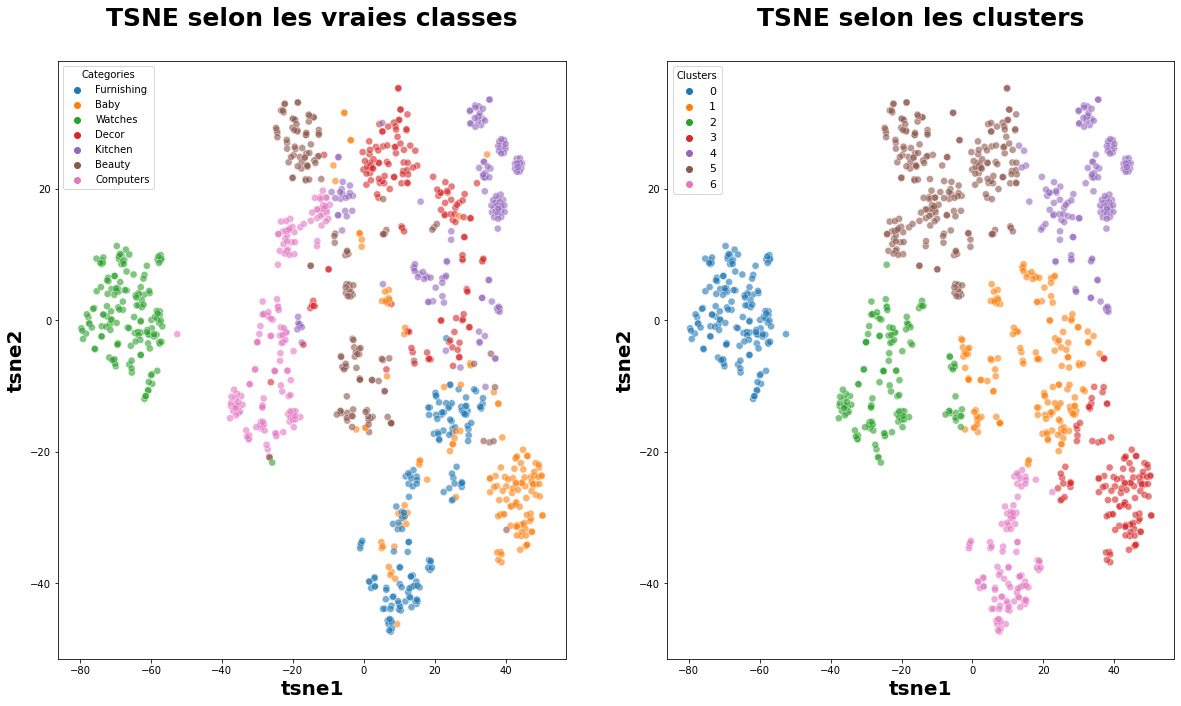

ARI :  0.4028


In [53]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Nous obtenons en utlisant universal sentence encoder un ARI de 0.4 dans le même ordre de grandeur des résultats obtenus via les techniques plus simple bag of words-Tf-idf.

## Prétraitements des images

Créons un dataframe utile à notre prolematique:

In [57]:
df = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')
df = detail_categories(df, 'product_category_tree')
df_pict = df[[ 'cat_level_1']].copy('deep')
df_pict  = df_pict .rename(columns={'cat_level_1': 'category'})
le = preprocessing.LabelEncoder()
df_pict["label"] = le.fit_transform(df_pict["category"])
df_pict.index = [s+'.jpg' for s in df_pict.index]
df_pict.head()

category  label
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing      4
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care      0
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care      0
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing      4
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing      4

### Affichage d'exemples d'images par label

Définissons des fonctions pour l'affichages des images par label:

In [58]:
def print_thumbnails_from_df(ser_pict, li_files, preproc_func=None,
                             preproc_params=None, n_rows=1,
                             figsize=(15,2), fig=None,
                             li_im_title=None, title=None):
    """ Function that displays thumbnails from dataframe.
    ----------
    Parameters:
               ser_pict: numpy array of image
               li_files: list files 
    """
    n_tot = len(li_files)
    n_cols = (n_tot//n_rows)+((n_tot%n_rows)>0)*1
    fig = plt.figure(figsize=figsize) if fig is None else fig
    for i, ind in enumerate(li_files,1):
        img = ser_pict.loc[ind]
        if preproc_func is not None:
            img = preproc_func(img, **preproc_params)
        ax = fig.add_subplot(n_rows,n_cols,i)
        if len(img.shape)==3:
            ax.imshow(img)
            if li_im_title is not None:
                ax.set_title(li_im_title[i-1])
        else:
            ax.imshow(img, cmap='Greys_r')
            if li_im_title is not None:
                ax.set_title(li_im_title[i-1])
        ax.set_axis_off()
        if title is not None:
            plt.suptitle(title, fontweight='bold')
    plt.show()

def print_sample_by_from_df(ser_pict, sercat, n_img=10, n_rows=1,
                            preproc_func=None, preproc_params=None,
                            figsize=(20,2)):
    """ Function that displays sample of image from dataframe.
    ----------
    Parameters:
               ser_pict: numpy array of image
    """
    gb = ser_pict.groupby(sercat)
    for name, sub_df in gb:
        li_files = sub_df.sample(n_img).index
        print_thumbnails_from_df(ser_pict, li_files,
                                 preproc_func,
                                 preproc_params,
                                 n_rows=n_rows,
                                 figsize=figsize,
                                 title=name)

 Créons une fonction pour importer les images et les mettre dans un dictionnaire:

In [59]:
file_path = 'C:/Users/33624/Documents/Data scientist/projet 6/Flipkart/Images/'
li_files = df_pict.index

def dict_image(li_files):
    """Function that creates image dictionnary.
    ----------
    Parameters:
               li_files: list of files image                       
    Returns:
               dict_img_orig : image dictionnary
                     
    """
    # to silence the decompression bomb warning
    Image.MAX_IMAGE_PIXELS = 1000000000  
    ## importing pictures
    dict_img_orig = {}
    # loop on the pictures in the file
    for i,ind in enumerate(li_files,1):
        print('\r', f"{i}/{len(list(li_files))}", end="")
        # cast each image to a np.array
        img = np.array(Image.open(file_path+ind))
        # put in the dictionnary
        dict_img_orig[ind] = img
    return dict_img_orig

Créons un dcitionnaire d'images et plaçons l'array des images d'origine dans une colonne nommée 'img_orig' dans le dataframe 'df_pict':

In [60]:
dict_img_orig = dict_image(li_files)
ser_img_orig = pd.Series(dict_img_orig,
                         index = df_pict.index,
                         name='img_orig')
df_pict = pd.concat([df_pict,
                     ser_img_orig.to_frame()], axis=1)

 1050/105026/1050706/1050

Affichons quelques images par catégories de produits: 

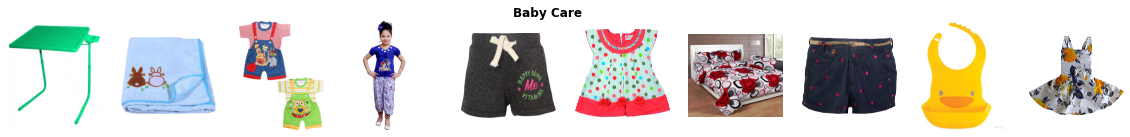

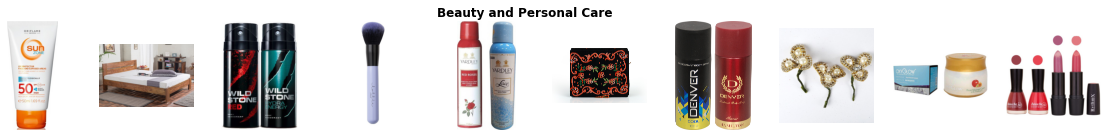

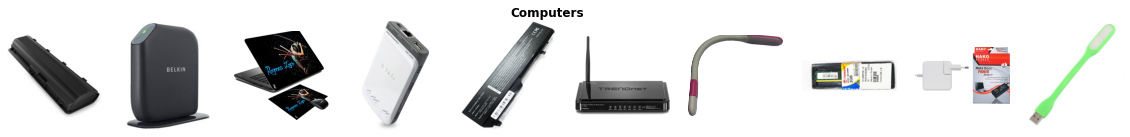

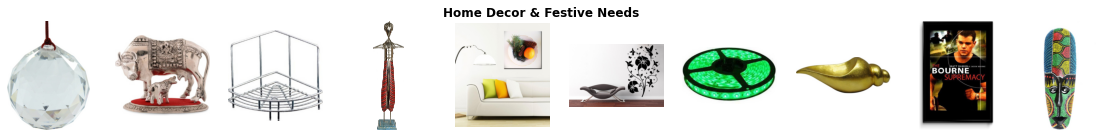

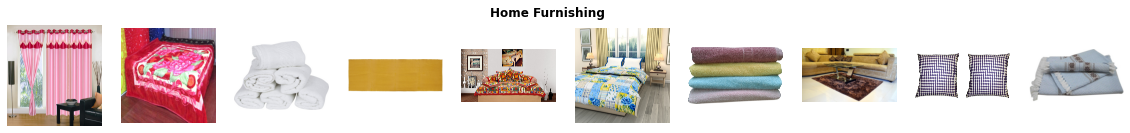

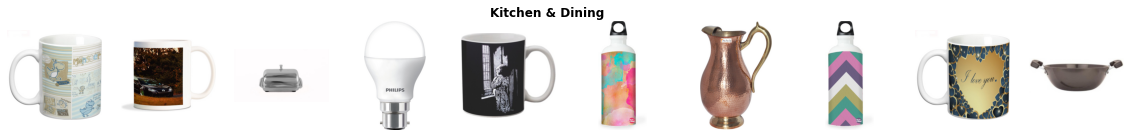

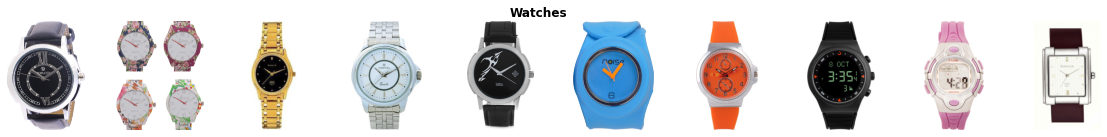

In [61]:
print_sample_by_from_df(df_pict['img_orig'], df_pict['category'],
                        n_img=10, n_rows=1, figsize=(20,2))

### Analyse d’une image

Créons une fonction pour un prétraitement de l'image:

In [104]:
def preprocess(path_image):
    """Function that pre-processes the image through:
    resizing, convert to grey scale, application of the gaussian and median filter
    and improvement of the contrast and display of the various associated histograms.
    ----------
    Parameters:
               path_image: path image         
                           
    Returns:
               image : image pre-processed
    """
                     
    # Opening the file
    img = Image.open(path_image)
    mat = np.array(img)
    
    # Resize the image to not exceed a height of 300 or a width of 200
    w,h = img.size
    downscale_factor = max(w // 200, h // 300 )
    downscale_w = int(w / downscale_factor)
    downscale_h = int(h / downscale_factor)
    down_points = (downscale_h, downscale_w)
    img_size=cv2.resize(mat, down_points, interpolation=cv2.INTER_LINEAR)
    
    # Greyscale
    grey_image = cv2.cvtColor(img_size,cv2.COLOR_BGR2GRAY)
    
    Fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    # Original image
    axs[0].imshow(img)
    axs[0].set_title( 'Original image\n' )
    axs[0].set_axis_off()
     # Grayscale image
    axs[2].imshow( grey_image, cmap = 'Greys_r')
    axs[2].set_title( 'Grayscale image\n' )
    axs[2].set_axis_off()
    # Image resized
    axs[1].imshow( img_size, cmap = 'Greys_r')
    axs[1].set_title( 'Image resized\n' )
    axs[1].set_axis_off()
    
    # Gaussian filter
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axs[0].imshow( grey_image, cmap = 'Greys_r')
    axs[0].set_title( 'Grayscale image\n' )
    axs[0].set_axis_off()
    gaussian_image = gaussian_filter( grey_image, 3)
    axs[1].imshow(  gaussian_image, cmap = 'Greys_r')
    axs[1].set_title( 'Image with Gaussian filter\n' )
    axs[1].set_axis_off()
    axs[2].hist(grey_image.flatten(), bins = 20, density = True , alpha = .5 , edgecolor = 'black', color = 'red' , 
                label = 'Original image')
    axs[2].hist(  gaussian_image.flatten(), bins = 20, density = True , alpha = .3 , edgecolor = 'black', color = 'blue', 
                label = 'Gaussian filter')
    axs[2].legend()
    axs[2].set_title( 'Pixel Histogram\n' )
    
    # Median filter
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axs[0].imshow( grey_image, cmap = 'Greys_r')
    axs[0].set_title( 'Grayscale image\n' )
    axs[0].set_axis_off()
    median_image = median_filter( grey_image, 3)
    axs[1].imshow(  median_image, cmap = 'Greys_r')
    axs[1].set_title( 'Image with median filter\n')
    axs[1].set_axis_off()
    axs[2].hist(grey_image.flatten(), bins = 20, density = True , alpha = .5 , edgecolor = 'black', color = 'red' , 
                label = 'Original image')
    axs[2].hist(  median_image.flatten(), bins = 20, density = True , alpha = .3 , edgecolor = 'black', color = 'blue', 
                label = 'Median filter')
    axs[2].legend()
    axs[2].set_title( 'Pixel Histogram\n' ) 
    
    # Equalize image histogram
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axs[0].imshow( median_image, cmap = 'Greys_r')
    axs[0].set_title( 'Image with median filter\n' )
    axs[0].set_axis_off()
    image = cv2.equalizeHist(median_image)
    axs[1].imshow(  image, cmap = 'Greys_r')
    axs[1].set_title( 'Image with contrast\n')
    axs[1].set_axis_off()
    axs[2].hist(median_image.flatten(), bins = 20, density = True , alpha = .5 , edgecolor = 'black', color = 'red' , 
                label = 'Image with median filter')
    axs[2].hist( image.flatten(), bins = 20, density = True , alpha = .3 , edgecolor = 'black', color = 'blue', 
                label = 'Image with contrast')
    axs[2].legend()
    axs[2].set_title('Pixel Histogram\n')
  
    return image

Prétraitons une image avec affichage des histogrammes:

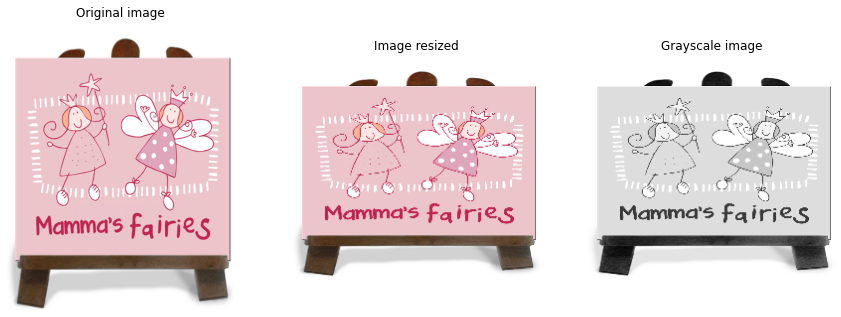

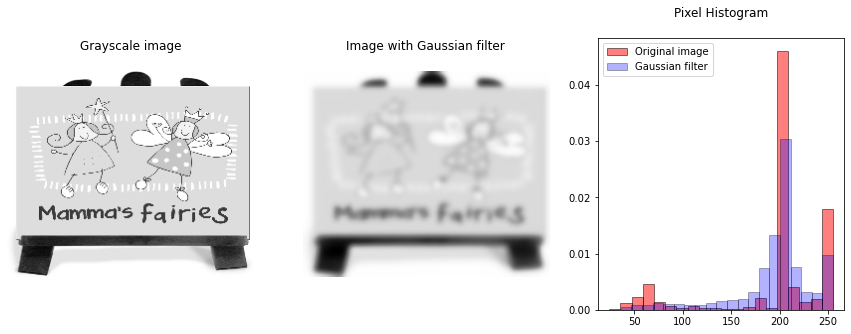

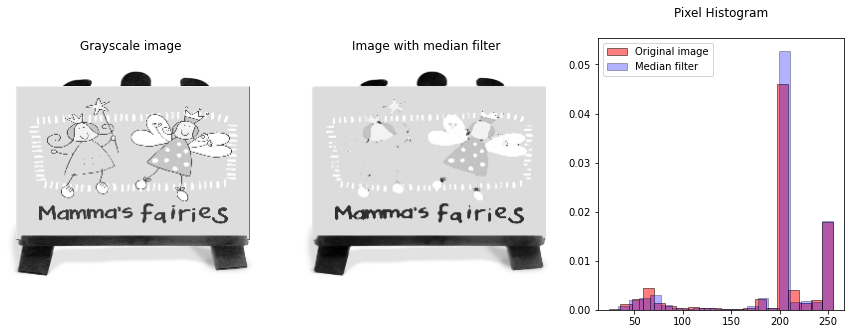

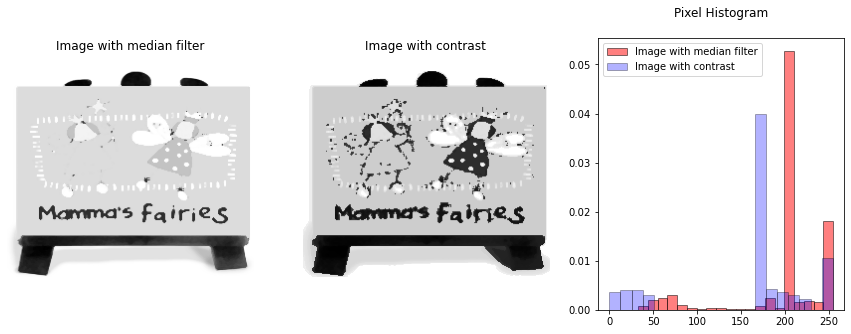

In [72]:
path_image = file_path + random.choice(li_files)
image = preprocess(path_image)

##  Prétraitement des images via SIFT 

Utlissons la fonction de prétraitement des images definie précedement sans affichage des histogrammes:

In [63]:
def preprocess(path_image):
    """ Function that pre-processes the image through:
    resizing, convert to grey scale, application of the median filter
    and improvement of the contrast and display.
    ----------
    Parameters:
               path_image: path image         
                           
    Returns:
               image : image pre-processed
    """
    # Opening the file
    img = Image.open(path_image)
    mat = np.array(img)
    
    # Resize the image to not exceed a height of 300 or a width of 200
    w,h = img.size
    downscale_factor = max(w // 200, h // 300 )
    downscale_w = int(w / downscale_factor)
    downscale_h = int(h / downscale_factor)
    down_points = (downscale_h, downscale_w)
    img_size=cv2.resize(mat, down_points, interpolation=cv2.INTER_LINEAR)
    
    # Greyscale
    grey_image = cv2.cvtColor(img_size,cv2.COLOR_BGR2GRAY)
    
    # Median filter
    median_image = median_filter( grey_image, 3)
    
    # Equalize image histogram
    image = cv2.equalizeHist(median_image)
  
    return image

Définissons une fonction qui affiche les descripteurs de l'agorithme SIFT:

In [64]:
def display_des(image):
    """ Function that displays the descriptors of 
    an image by the sift method.
    ----------
    Parameters:
               image : image pre-processed        
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    img = cv2.drawKeypoints(image,kp,image)
    fig, axs = plt.subplots(figsize=(5,5))
    fig = plt.imshow(img)
    axs.set_axis_off()
    title = plt.title('Descripteurs via SIFT\n' , fontsize=18)
    plt.show()
    print('------------------------------------')
    print("Descripteurs : ", des.shape)
    print('------------------------------------')
    print(des)

Affichons les descripteurs d'une image:

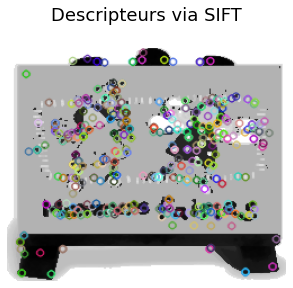

------------------------------------
Descripteurs :  (392, 128)
------------------------------------
[[  0.   0.   0. ...   0.   1.   6.]
 [118. 141.   0. ...   0.   0.   1.]
 [  0.   0.   0. ...   0.   0.  21.]
 ...
 [  2.  71.  45. ...   0.   0.   0.]
 [  0.   6.  38. ...   0.   0.   0.]
 [ 17.   9.   3. ...   0.   0.   0.]]


In [81]:
display_des(image)

### Création des descripteurs pour chaque image
Définissons une fonction pour effectuer les operations suivantes:
* Chaque image  subie au préalable un prétraitement(redimentionnement, passage au gris, filtre et constraste)
* Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [65]:
def sift_desc(df, file_path):
    """ Function that creates the descriptors of 
    all images by the sift method.
    ----------
    Parameters:
               df : dataframe
               file_path: file path image
                           
    Returns:
               sift_keypoints_by_img : the descriptors by image
               sift_keypoints_all : the descriptors for all images
    """
    # identification of key points and associated descriptors
    sift_keypoints = []
    temps1=time.time()
    sift = cv2.SIFT_create(2000)
    for image_num in range(len(df)) :
        image = preprocess(file_path + df.index[image_num])
        kp, des = sift.detectAndCompute(image, None)
        sift_keypoints.append(des)
    sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
    sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)
    print()
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)
    duration1=time.time()-temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")
    return sift_keypoints_by_img, sift_keypoints_all

Créons nos descripteurs:

In [66]:
sift_keypoints_by_img, sift_keypoints_all = sift_desc(df_pict, file_path)


Nombre de descripteurs :  (378634, 128)
temps de traitement SIFT descriptor :            45.14 secondes


### Création des clusters de descripteurs
 Créons les clusters des descripteurs via l'algorithme  MiniBatchKMeans pour obtenir des temps de traitement raisonnables:

In [67]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, batch_size=2048)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  615
Création de 615 clusters de descripteurs ...
temps de traitement kmeans :             6.01 secondes


### Création des features des images
Définissons une fonction pour effectuer les opérations suivantes:
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
   
Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [68]:
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    """ Function that creates the histograms of image (features).
    ----------
    Parameters:
               kmeans : kmeans algorithm
               des: image descriptors
               image_num: numero of image                        
    Returns:
               hist: the histograms of image (features)
    """
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


def matrix_hist(sift_keypoints_by_img):
    """ Function that creates the matrix of histograms.
    ----------
    Parameters:
               sift_keypoints_by_img : sift decriptors by image                       
    Returns:
               im_features: images features
    """
    hist_vectors=[]
    for i, image_desc in enumerate(sift_keypoints_by_img) :
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector
    im_features = np.asarray(hist_vectors)
    duration1=time.time()-temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
    return im_features 

Créons les features des images:

In [69]:
im_features = matrix_hist(sift_keypoints_by_img)

temps de création histogrammes :            96.54 secondes


### Réduction de dimension PCA
Effectuons une réduction PCA pour créer des features décorrélées entre elles, et  diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%) afin d'avoir un impact meilleur dans la séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [70]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 615)
Dimensions dataset après réduction PCA :  (1050, 487)


### Affichage des résultats

In [71]:
ARI, df_tsne, labels = ARI_fct(feat_pca,  df_product["category"])

ARI :  0.0467 time :  12.0


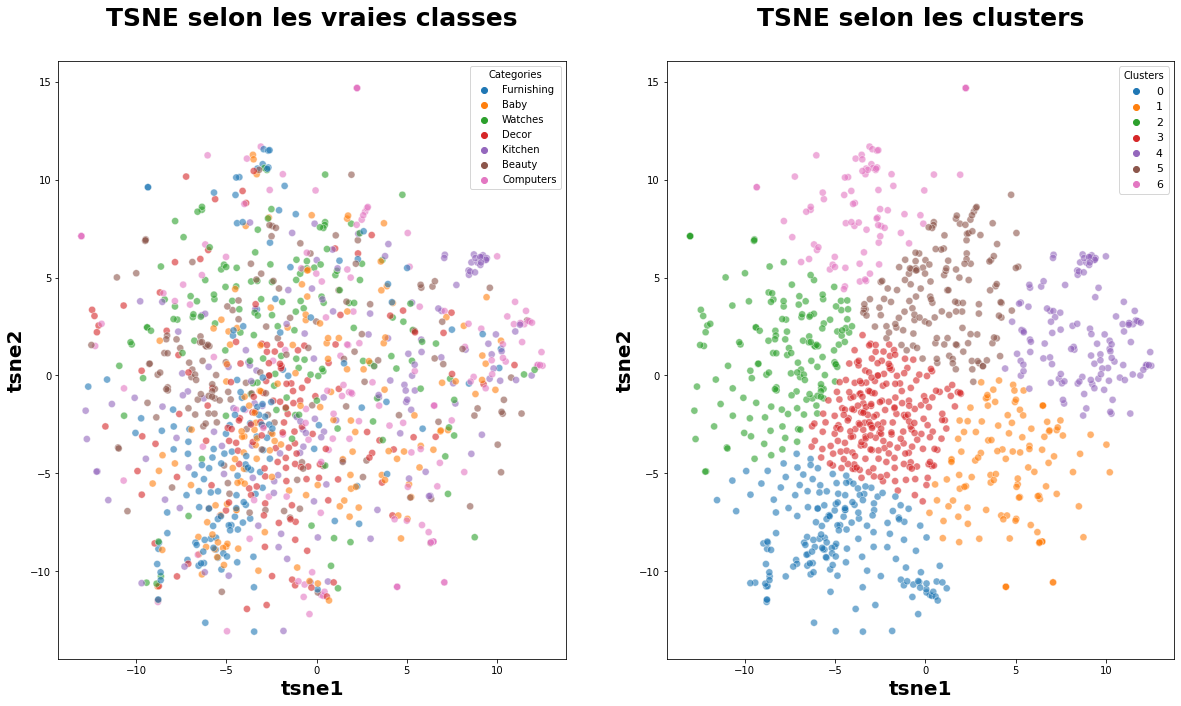

ARI :  0.0467


In [72]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Il en ressort de l'analyse visuelle du grahique le T-SNE selon les vrais classes qu'il est assez difficile de séparer les images selon le label.

La similarité de la catégorisation (catégorie réelle / cluster k-means) via l’Adjusted Rand Score (ARI) donne un résultat de l’ordre de 0.05 confirmant ainsi l'impression le visuelle.

Le résultat de classification automatique d’images n’est donc pas très concluant avec SIFT.

## Prétraitement des images via CNN Transfer Learning

Nous ferons du tansfer learning en utlissant le model pré-entrainé VGG16:

### Création des features des images
Définissons une fonction pour extraire les features des images via le transfer learning en utlisant le model pre-entrainé VGG16 auquel nous éliminons la derniére couche relative à la classification des images:

In [73]:
def features_vgg16(df, file_path):
    """ Function that use the Pre-Trained Model VGG16 as Feature Extractor Preprocessor.
    ----------
    Parameters:
               df : dataframe
               file_path: file path image                      
    Returns:
               im_features: images features
    """
    features_vectors=[]
    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    for image_num in range(len(df)):
        # load an image from file
        image = load_img(file_path + df.index[image_num], target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get extracted features
        features = model.predict(image)
        features_vectors.append(features)
    im_features= np.concatenate(features_vectors, axis=0)
    duration1=time.time()-temps1
    print("temps de création features via CNN : ", "%15.2f" % duration1, "secondes")
    return im_features 

Réalisons l'extraction des features:

In [74]:
im_features = features_vgg16(df_pict, file_path)

1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 234ms/step
temps de création features via CNN :           456.28 secondes


### Réduction de dimension PCA
Effectuons une réduction PCA pour créer des features décorrélées entre elles, et  diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%) afin d'avoir un impact meilleur dans la séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [75]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


### Affichage des résultats

In [76]:
ARI, df_tsne, labels = ARI_fct(feat_pca,  
                      df_product["category"])

ARI :  0.4803 time :  10.0


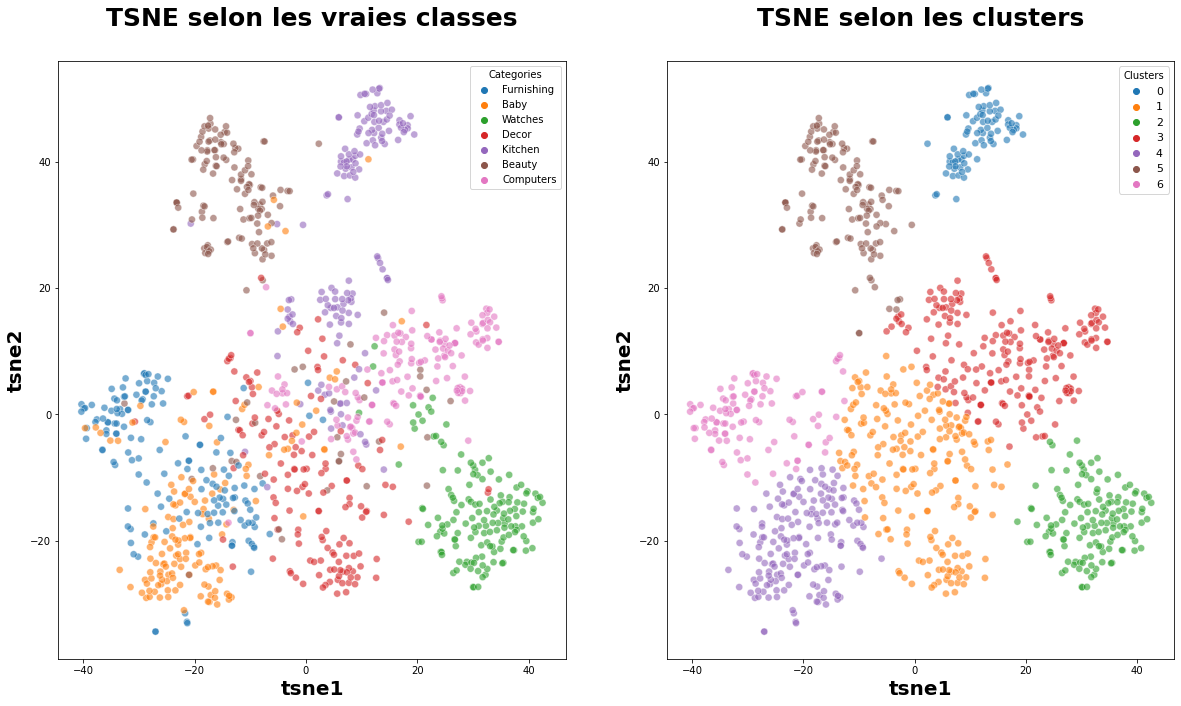

ARI :  0.4803


In [77]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)

Le graphique T-sne des catégorie réelles montre assez clairement que les images sont relativement bien séparés selon les catégories réelles, la comparaison de la similarité de la catégorisation (catégorie réelle / cluster k-means) via l’adjusted Rand Score (ARI) donne une valeur 0.5 et montre, sans entraînement d’un modèle, la faisabilité de réaliser une classification automatique des images.

### Resnet

In [9]:
import tensorflow.keras.applications as app
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten

In [10]:
# getting the convolutional base of a ResNet50 CNN 
conv_base = ResNet50(weights='imagenet',
                           include_top=False, # remove the last layer
                           input_shape=(224,224,3))
# conv_base.summary()

94765736/94765736 [==============================] - 16s 0us/step


In [11]:
### Creation of the cnn model to extract features

# add resnet50 convolutional base to our model
cnn_model = Sequential()
cnn_model.add(conv_base)

# add layer for dimensional reduction (global max pooling) 
cnn_model.add(GlobalMaxPooling2D())
### GlobalaveragePooling à tester
# additionner les résultats des gloabl max et global average
# add layer for flattening
# cnn_model.add(Flatten()) # pas forcément nécessaire

# print summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [120]:
features_vectors=[]
for image_num in range(len(df)):
    image = load_img(file_path + df_pict.index[image_num], target_size=(224, 224))
        # convert the image pixels to a numpy array
    img = img_to_array(image)
        # reshape img (np.array) to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # preprocess images
    img = imagenet_utils.preprocess_input(img, data_format=None, mode='caffe')
    
    # img = app.resnet50.preprocess_input(img)

    # get the extracted features
    features = cnn_model.predict(img)
    features_vectors.append(features)
im_features= np.concatenate(features_vectors, axis=0)
duration1=time.time()-temps1

1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 165ms/step


In [123]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 812)


In [124]:
ARI, df_tsne, labels = ARI_fct(feat_pca,  
                      df_product["category"])

ARI :  0.5251 time :  11.0


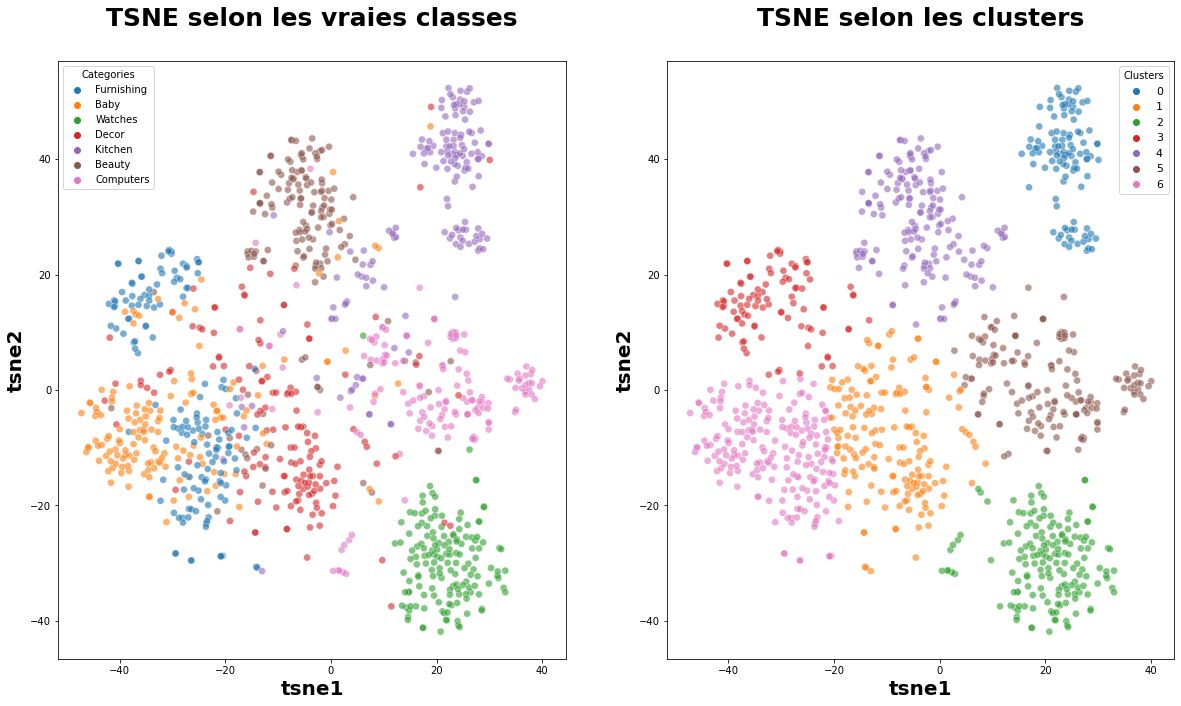

ARI :  0.5251


In [125]:
TSNE_visu_fct(df_tsne, cat_num, labels, ARI)